In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.signal import hilbert, savgol_filter, find_peaks
from scipy.interpolate import interp1d
from symreg import Promising_solution, Solution, Problem, create_arbitrary_constraint
import sympy as sp
from typing import List, Tuple

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


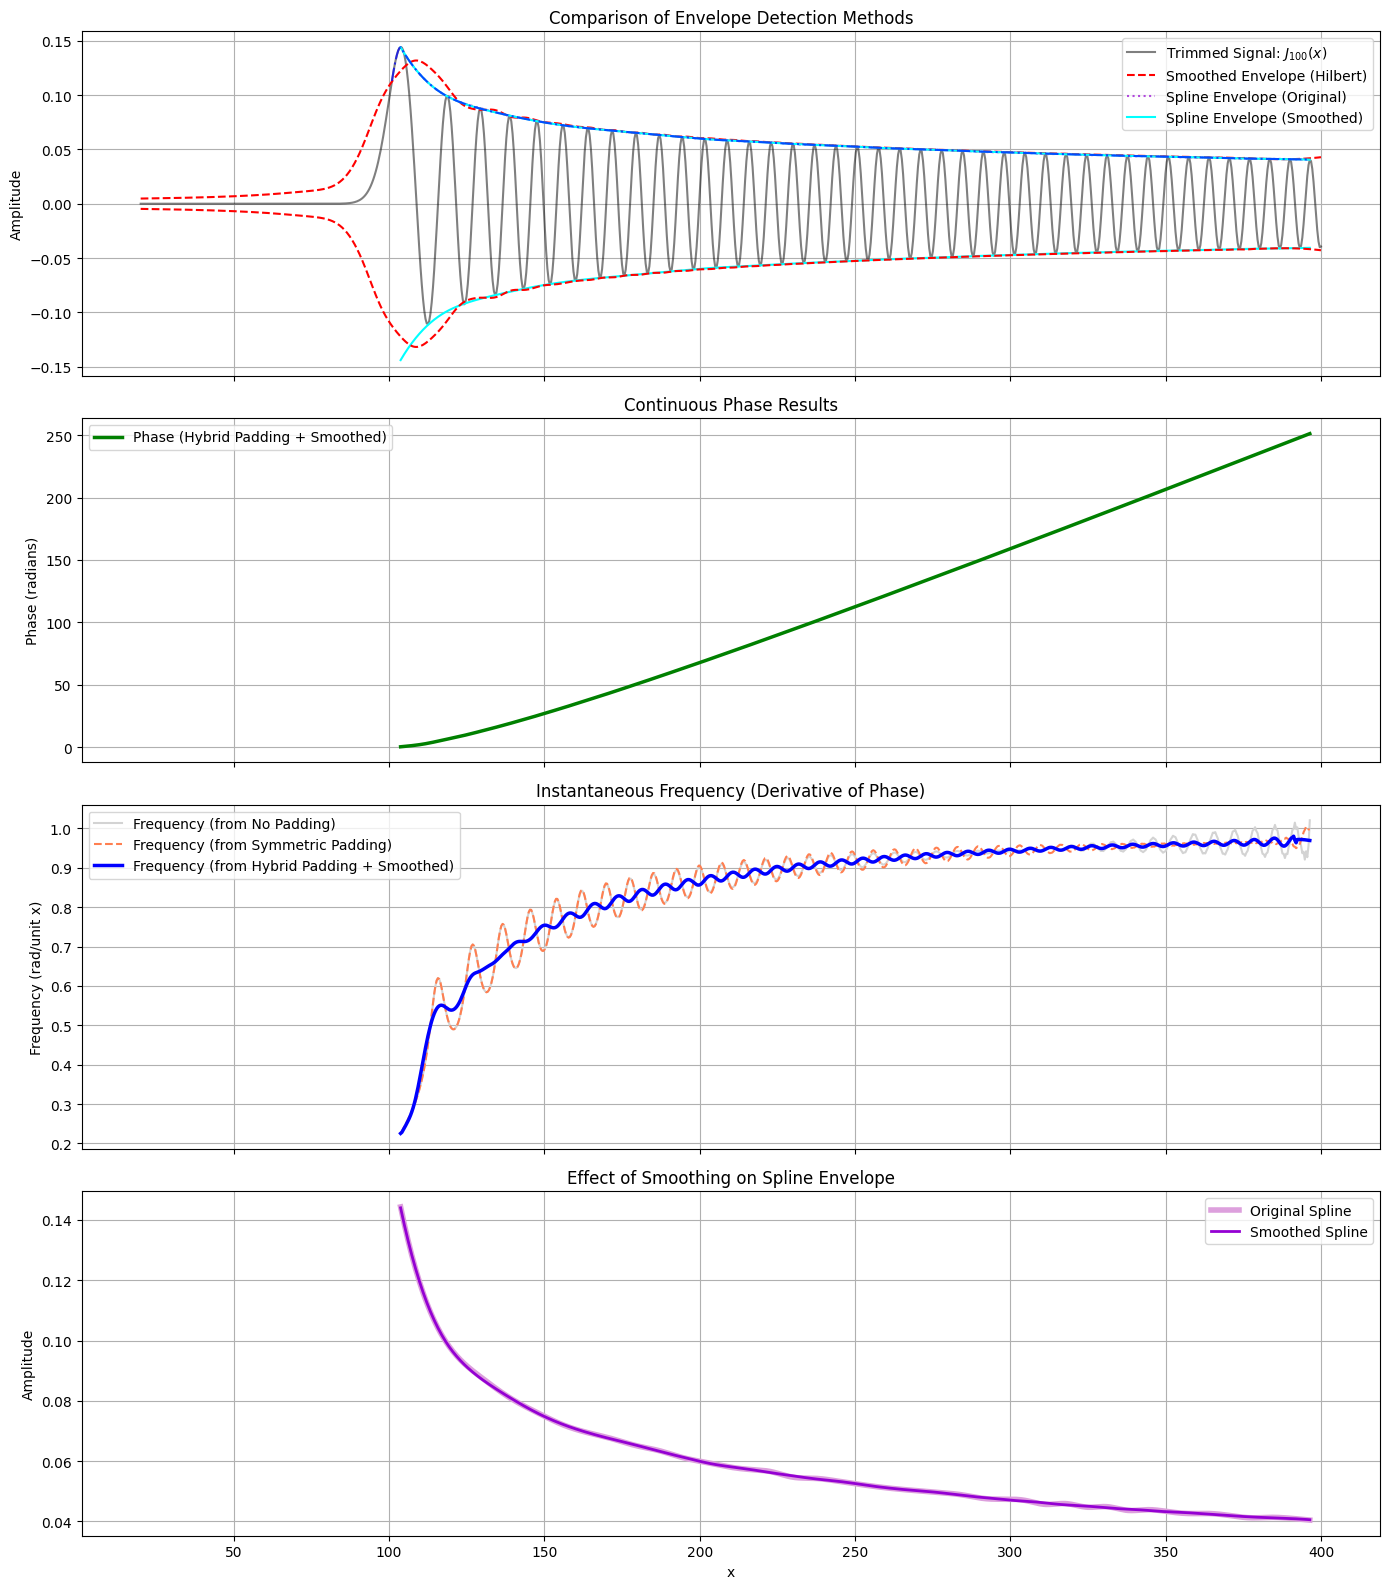

In [52]:

# --- Step 1: Generate Original Signal ---
order = 100
x_data_hilbert = np.linspace(0, 400, 1000) 
y_true_bessel = special.jv(order, x_data_hilbert)
dt = x_data_hilbert[1] - x_data_hilbert[0]

# --- Step 2: Robust Hilbert Transform using HYBRID Padding ---
pad_width = int(len(y_true_bessel) * 0.10)
fit_points = 50 
y_padded_for_start = np.pad(y_true_bessel, (pad_width, 0), mode='symmetric')
y_start_pad = y_padded_for_start[:pad_width]
end_coeffs = np.polyfit(x_data_hilbert[-fit_points:], y_true_bessel[-fit_points:], 1)
end_poly = np.poly1d(end_coeffs)
x_end_pad = np.arange(1, pad_width + 1) * dt + x_data_hilbert[-1]
y_end_pad = end_poly(x_end_pad)
y_padded = np.concatenate([y_start_pad, y_true_bessel, y_end_pad])
analytic_signal_padded = hilbert(y_padded)
analytic_signal = analytic_signal_padded[pad_width:-pad_width]

# --- For comparison purposes only ---
analytic_signal_simple = hilbert(y_true_bessel)
y_padded_symm_full = np.pad(y_true_bessel, pad_width, mode='symmetric')
analytic_signal_symm_full = hilbert(y_padded_symm_full)
analytic_signal_symm = analytic_signal_symm_full[pad_width:-pad_width]

# --- Step 3: Extract and Polish Phase ---
target_amplitude = np.abs(analytic_signal)
target_phase = np.unwrap(np.angle(analytic_signal))
phase_window = 41 
phase_polyorder = 3
target_phase = savgol_filter(target_phase, phase_window, phase_polyorder)

# Get phases for comparison plot
target_phase_simple = np.unwrap(np.angle(analytic_signal_simple))
target_phase_symm = np.unwrap(np.angle(analytic_signal_symm))

# --- Step 4: Trim the Edges ---
trim_percent = 5.0
trim_points = int(len(x_data_hilbert) * trim_percent / 100)
x_data_trimmed = x_data_hilbert[trim_points:]
y_true_bessel_trimmed = y_true_bessel[trim_points:]
target_amplitude_trimmed = target_amplitude[trim_points:] 
target_phase_trimmed = target_phase[trim_points:]
target_phase_simple_trimmed = target_phase_simple[trim_points:]
target_phase_symm_trimmed = target_phase_symm[trim_points:]

# --- Step 5: Envelope Processing and Final Slicing ---
window_length = 101 
polyorder = 3
smooth_amplitude_trimmed = savgol_filter(target_amplitude_trimmed, window_length, polyorder) 
peaks_indices, _ = find_peaks(y_true_bessel_trimmed, distance=10) 
x_peaks = x_data_trimmed[peaks_indices]
y_peaks = y_true_bessel_trimmed[peaks_indices]
envelope_function = interp1d(x_peaks, y_peaks, kind='cubic', bounds_error=False, fill_value=0)
spline_amplitude_trimmed = envelope_function(x_data_trimmed)
spline_amplitude_trimmed[spline_amplitude_trimmed < 0] = 0
first_peak_index = peaks_indices[0]
last_peak_index = peaks_indices[-1]
x_data_spline_final = x_data_trimmed[first_peak_index : last_peak_index + 1]
spline_amplitude_final = spline_amplitude_trimmed[first_peak_index : last_peak_index + 1]

# Slice all phase versions for the final plot
target_phase_spline_final = target_phase_trimmed[first_peak_index : last_peak_index + 1] 
target_phase_simple_spline_final = target_phase_simple_trimmed[first_peak_index : last_peak_index + 1]
target_phase_symm_spline_final = target_phase_symm_trimmed[first_peak_index : last_peak_index + 1]

# --- NEW: Step 5D: Smooth the final spline envelope ---
# A smaller window is often better for an already smooth spline
spline_window = 91
spline_polyorder = 3
spline_amplitude_smoothed = savgol_filter(spline_amplitude_final, spline_window, spline_polyorder)
# --- END NEW ---

# --- Step 5E: Calculate Instantaneous Frequency (Derivative of Phase) ---
inst_freq_simple = np.gradient(target_phase_simple_spline_final, x_data_spline_final)
inst_freq_symm = np.gradient(target_phase_symm_spline_final, x_data_spline_final)
inst_freq_final = np.gradient(target_phase_spline_final, x_data_spline_final)


# --- Step 5F: Create Smoothed Spline + prepeak values ---
s=7  # Number of points before the first peak to include
prepeak_vals = x_data_trimmed[first_peak_index-s:first_peak_index]
x_data_combined = np.concatenate((prepeak_vals, x_data_spline_final))
spline_amplitude_combined = np.concatenate((special.jv(order, prepeak_vals), spline_amplitude_smoothed))


# --- Step 6: Visualize All Results ---
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# Plot 1: Amplitude Envelopes
ax1.plot(x_data_trimmed, y_true_bessel_trimmed, label=f'Trimmed Signal: $J_{{{order}}}(x)$', color='k', alpha=0.5)
ax1.plot(x_data_trimmed, smooth_amplitude_trimmed, label='Smoothed Envelope (Hilbert)', color='red', linestyle='--')
ax1.plot(x_data_spline_final, spline_amplitude_final, label='Spline Envelope (Original)', color='darkviolet', linestyle=':', alpha=0.7)

# MODIFIED I: Plot the new smoothed spline
ax1.plot(x_data_spline_final, spline_amplitude_smoothed, label='Spline Envelope (Smoothed)', color='cyan', linestyle='-')
ax1.plot(x_data_spline_final, -spline_amplitude_smoothed, color='cyan', linestyle='-')
ax1.plot(x_data_trimmed, -smooth_amplitude_trimmed, color='red', linestyle='--')
ax1.set_title('Comparison of Envelope Detection Methods')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True)

# MODIFIED II: Include spline with prepeak values
ax1.plot(x_data_combined, spline_amplitude_combined, label='Spline Envelope (with Prepeak)', color='blue', linestyle='-.', alpha=0.7)


# Plot 2: Unwrapped Phase
#ax2.plot(x_data_spline_final, target_phase_simple_spline_final, label='Phase (No Padding)', color='lightgray')
#ax2.plot(x_data_spline_final, target_phase_symm_spline_final, label='Phase (Symmetric Padding)', color='coral', linestyle='--')
ax2.plot(x_data_spline_final, target_phase_spline_final, label='Phase (Hybrid Padding + Smoothed)', color='green', linewidth=2.5)
ax2.set_title('Continuous Phase Results')
ax2.set_ylabel('Phase (radians)')
ax2.legend()
ax2.grid(True)

# Plot 3: Instantaneous Frequency
ax3.plot(x_data_spline_final, inst_freq_simple, label='Frequency (from No Padding)', color='lightgray')
ax3.plot(x_data_spline_final, inst_freq_symm, label='Frequency (from Symmetric Padding)', color='coral', linestyle='--')
ax3.plot(x_data_spline_final, inst_freq_final, label='Frequency (from Hybrid Padding + Smoothed)', color='blue', linewidth=2.5)
ax3.set_title('Instantaneous Frequency (Derivative of Phase)')
ax3.set_ylabel('Frequency (rad/unit x)')
ax3.legend()
ax3.grid(True)

# MODIFIED: Plot 4: Original Spline vs. Smoothed Spline
ax4.plot(x_data_spline_final, spline_amplitude_final, label='Original Spline', color='plum', linewidth=4)
ax4.plot(x_data_spline_final, spline_amplitude_smoothed, label='Smoothed Spline', color='darkviolet', linestyle='-', linewidth=2)
ax4.set_title('Effect of Smoothing on Spline Envelope')
ax4.set_ylabel('Amplitude')
ax4.set_xlabel('x')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

In [55]:
amplitude_bessel_0_args = {
    'allowed_symbols': "add,sub,mul,div,constant,variable,sqrt",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'], 
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 60,
    'max_time': 60*4,
    'n_threads': 12,
    'tournament_size': 6
}

amplitude_bessel_0 = Problem(f"Amplitude of Bessel (Hilbert decomp) of {order}", (x_data_combined,  spline_amplitude_combined), (x_data_combined,  spline_amplitude_combined), amplitude_bessel_0_args)

<Axes: title={'center': 'Amplitude of Bessel (Hilbert decomp) of 100 train'}, xlabel='X-axis', ylabel='Y-axis'>

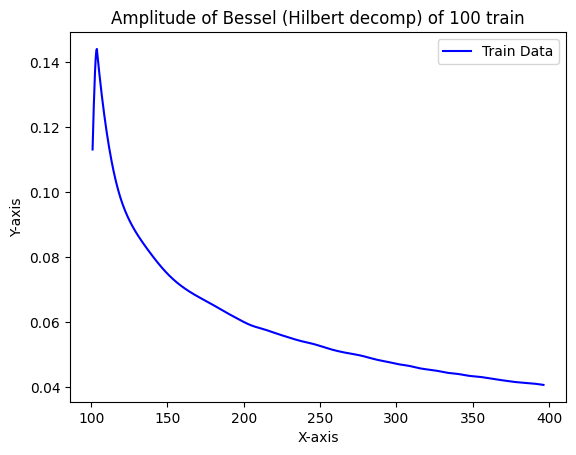

In [56]:
amplitude_bessel_0.plot_data()

In [57]:
amplitude_bessel_0.solve()

[0.010550081729888916, 5.0], 687.19, (0.110616773366928101 + ((-0.000482823146739975) * (0.425128817558288574 * X1))), 0.00
[0.009266012348234653, 6.0], 691.83, (0.160697013139724731 + ((-0.005531719885766506) * sqrt((1.387605667114257812 * X1)))), 0.00
[0.004984174855053425, 7.0], 691.39, (0.010974396020174026 + ((-0.581140816211700439) * (3.264970302581787109 / ((-0.180846810340881348) * X1)))), 0.00
[0.00217934837564826, 9.0], 701.08, ((-0.025028098374605179) + (0.003622494637966156 * ((0.522408008575439453 * X1) / ((0.033751793205738068 * X1) - 2.243159294128417969)))), 0.00
[0.0020161450374871492, 10.0], 699.70, (0.012384195812046528 + (0.060597632080316544 * sqrt((2.350799560546875000 / ((0.033630836755037308 * X1) - 2.889678239822387695))))), 0.00
[0.001928454264998436, 11.0], 706.26, (0.016333535313606262 + ((-0.000846505921799690) * ((0.045475859194993973 * X1) - ((1.262984514236450195 * X1) / ((0.033751793205738068 * X1) - 2.581664323806762695))))), 0.00
[0.001240699901245534

<Axes: title={'center': 'Amplitude of Bessel (Hilbert decomp) of 100 - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

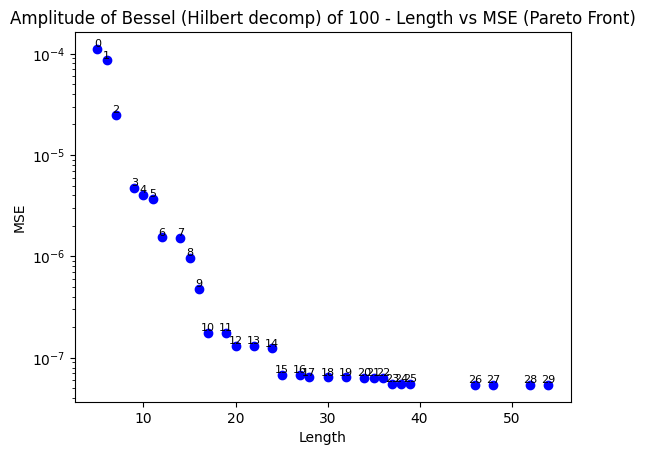

In [58]:
amplitude_bessel_0.plot_l_vs_mse()

b0 + b1/(sqrt(X1)*b2 + b6 - sqrt(X1*b3 - b4)/(X1*b3 - b5))


<IPython.core.display.Math object>

{'b0': 0.0036522874142974615,
 'b1': 0.20555153837310058,
 'b2': 0.29403999299233874,
 'b3': 0.03363083675503731,
 'b4': 3.3761396408081055,
 'b5': 3.264970302581787,
 'b6': 0.010276362299919128}

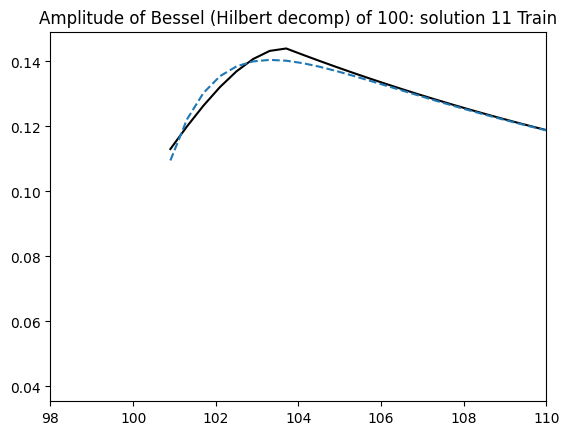

In [112]:
c_amp = 11
print(amplitude_bessel_0.solutions[c_amp].sympy_expr)
amplitude_bessel_0.solutions[c_amp].plot_results()
plt.xlim(98, 110)
amplitude_bessel_0.solutions[c_amp].display_expression()
amplitude_bessel_0.solutions[c_amp].b_vals

In [113]:
candidate_str_ampl =  'b1/(sqrt(X1)*b2 + b6 - sqrt(X1*b3 - b4)/(X1*b3 - b5))'
Candidate_ampl = Promising_solution(sp.parsing.sympy_parser.parse_expr(candidate_str_ampl), (x_data_spline_final, spline_amplitude_final), amplitude_bessel_0.solutions[c_amp], amplitude_bessel_0.solutions[c_amp].b_vals)

In [116]:
manual_expression_string = "b1/b2"
manual_target_value =  np.sqrt(2/np.pi)
full_param_symbols = [sp.Symbol(f'b{i}') for i in range(5)]

parameter_limit_inf_constraint = create_arbitrary_constraint(manual_expression_string, manual_target_value, full_param_symbols ,constraint_type='eq')
constraints_man = []
constraints_man.append(parameter_limit_inf_constraint)

Candidate_ampl.optimisation()
#Candidate_ampl.optimisation()

`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 588, CG iterations: 236, optimality: 1.47e-04, constraint violation: 0.00e+00, execution time: 0.11 s.

Optimization summary:
Parameter | Old Value | New Value | Abs Difference
--------- | --------- | --------- | --------------
b1        | 0.205552  | 0.218016  | 0.0124649     
b2        | 0.29404   | 0.269517  | 0.0245233     
b3        | 0.0336308 | 0.0339038 | 0.000272953   
b4        | 3.37614   | 3.38047   | 0.0043341     
b5        | 3.26497   | 3.2806    | 0.0156282     
b6        | 0.0102764 | 0.33144   | 0.321163      



(0.218016420837028/(0.269516708205992*sqrt(X1) - sqrt(0.0339037898275987*X1 - 3.3804737390008)/(0.0339037898275987*X1 - 3.28059850678005) + 0.331439647601386),
 {'b1': np.float64(0.21801642083702774),
  'b2': np.float64(0.26951670820599183),
  'b3': np.float64(0.03390378982759867),
  'b4': np.float64(3.380473739000799),
  'b5': np.float64(3.280598506780052),
  'b6': np.float64(0.3314396476013858)},
 {'b1': np.float64(0.012464882463927157),
  'b2': np.float64(0.02452328478634691),
  'b3': np.float64(0.0002729530725613591),
  'b4': np.float64(0.004334098192693592),
  'b5': np.float64(0.01562820419826494),
  'b6': np.float64(0.32116328530146665)},
 np.float64(0.004023735894926944))

<lambdifygenerated-809>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.218016420837028/(0.269516708205992*sqrt(X1) - sqrt(0.0339037898275987*X1 - 3.3804737390008)/(0.0339037898275987*X1 - 3.28059850678005) + 0.331439647601386)


{'b1': np.float64(0.21801642083702774),
 'b2': np.float64(0.26951670820599183),
 'b3': np.float64(0.03390378982759867),
 'b4': np.float64(3.380473739000799),
 'b5': np.float64(3.280598506780052),
 'b6': np.float64(0.3314396476013858)}

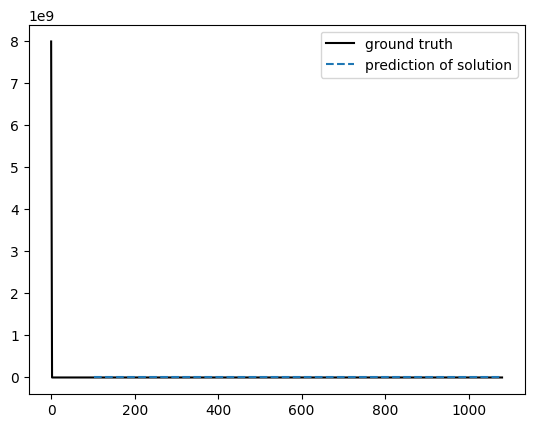

In [575]:
x_data = np.linspace(1e-20, 1080, 500)

Candidate_ampl.plot_comparison(x_data, np.sqrt(2/(np.pi*x_data)))
Candidate_ampl.modified_parameters
#Candidate_ampl.plot_comparison()

In [120]:
phase_bessel_0_args = {
    'allowed_symbols': "add,sub,mul,div,constant,variable",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'], 
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*3,
    'n_threads': 12,
}

phase_bessel_0 = Problem(f"Phase of Bessel (Hilbert decomp) of {order}", (x_data_spline_final, target_phase_spline_final), (x_data_spline_final, target_phase_spline_final), phase_bessel_0_args)

In [121]:
phase_bessel_0.solve()

[3.7576375007629395, 5.0], 5874.05, ((-106.253440856933593750) + (3.148692369461059570 * (0.282106697559356689 * X1))), 14.12
[3.7190868854522705, 7.0], 5805.15, ((-106.068824768066406250) + (15127.331054687500000000 * (((-1.573638677597045898) * X1) - ((-1.573697328567504883) * X1)))), 13.83
[0.23898786306381226, 9.0], 751.42, ((-165.490417480468750000) + (32.139694213867187500 * ((2.314341545104980469 / (0.012160311453044415 * X1)) + (0.031520254909992218 * X1)))), 0.06
[0.07843414694070816, 11.0], 739.93, ((-150.645477294921875000) + (8.099290847778320312 * ((5.071843147277832031 / ((-0.392295330762863159) + (0.012060686945915222 * X1))) + (0.122210159897804260 * X1)))), 0.01
[0.07843277603387833, 13.0], 748.58, ((-163.478683471679687500) + (8.099292755126953125 * (((5.071843147277832031 / ((-0.392295330762863159) + (0.012060686945915222 * X1))) + (0.122210159897804260 * X1)) + 1.584474205970764160))), 0.01
[0.06135435774922371, 15.0], 757.18, ((-153.434661865234375000) + (6.4525885

<Axes: title={'center': 'Phase of Bessel (Hilbert decomp) of 100 - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

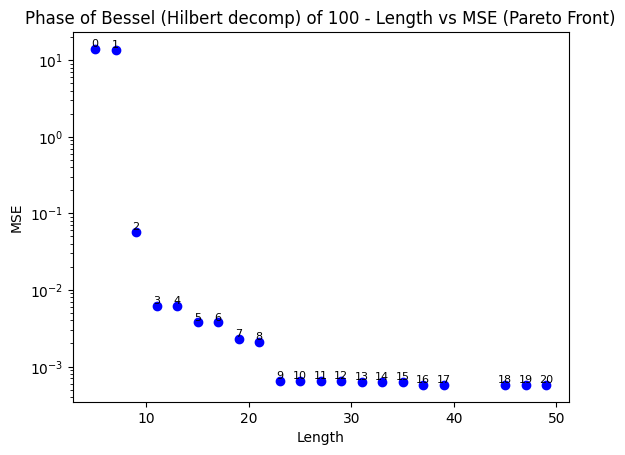

In [122]:
phase_bessel_0.plot_l_vs_mse()

X1**2*b0/(X1*b1 - b2) + X1*b3/(X1*b1 - b2) - b4 + b5/(X1*b6 - b7 + b8/X1)


<IPython.core.display.Math object>

{'b0': 0.30584012319559406,
 'b1': 0.3055926561355591,
 'b2': 1.294105052947998,
 'b3': 350.18026536883553,
 'b4': 1308.38623046875,
 'b5': 50.87235359536862,
 'b6': 0.4942751218878243,
 'b7': 43.85918006634165,
 'b8': 176.86832627939293}

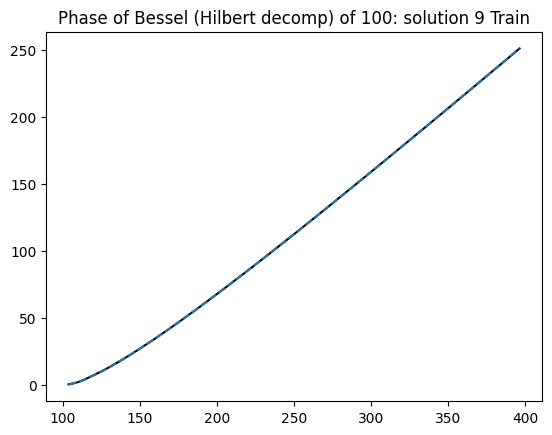

In [124]:
c_phi = 9
print(str(phase_bessel_0.solutions[c_phi].sympy_expr))
phase_bessel_0.solutions[c_phi].plot_results()
phase_bessel_0.solutions[c_phi].display_expression()
phase_bessel_0.solutions[c_phi].b_vals


In [127]:
candidate_str = 'X1**2*b0/(X1*b0 - b2) + X1*b3/(X1*b1 - b2) - b4 + b5/(X1*b6 - b7 + b8/X1)'
#f'X1 - ({order}*pi/2 + pi/4) - b2/(-X1**3*b3 + X1**2*b4) - b5/(-X1**2*b6 + X1*b7) + b8/X1'

Candidate_phase = Promising_solution(sp.parsing.sympy_parser.parse_expr(candidate_str), (x_data_spline_final, target_phase_spline_final), phase_bessel_0.solutions[c_phi], phase_bessel_0.solutions[c_phi].b_vals)

In [128]:
manual_expression_string = "b3/b1 - b4"
manual_target_value =  -(order*np.pi/2+np.pi/4)
full_param_symbols = [sp.Symbol(f'b{i}') for i in range(len(Candidate_phase.initial_params))]

parameter_limit_inf_constraint = create_arbitrary_constraint(manual_expression_string, manual_target_value, full_param_symbols ,constraint_type='eq')
constraints_man = []
constraints_man.append(parameter_limit_inf_constraint)

Candidate_phase.optimisation()

`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 590, CG iterations: 208, optimality: 1.56e+04, constraint violation: 0.00e+00, execution time: 0.095 s.

Optimization summary:
Parameter | Old Value | New Value | Abs Difference
--------- | --------- | --------- | --------------
b0        | 0.30584   | 0.305952  | 0.000112226   
b1        | 0.305593  | 0.305462  | 0.000130704   
b2        | 1.29411   | 1.2788    | 0.0153046     
b3        | 350.18    | 350.18    | 2.13563e-05   
b4        | 1308.39   | 1308.39   | 2.84989e-05   
b5        | 50.8724   | 50.8723   | 4.68306e-06   
b6        | 0.494275  | 0.489198  | 0.00507707    
b7        | 43.8592   | 43.8592   | 6.66566e-05   
b8        | 176.868   | 176.868   | 7.45406e-07   



(0.305952348831512*X1**2/(0.305952348831512*X1 - 1.27880048675039) + 350.180286725089*X1/(0.305461952281307*X1 - 1.27880048675039) - 1308.38620196982 + 50.8723489123085/(0.489198049652874*X1 - 43.859246722962 + 176.868325533987/X1),
 {'b0': np.float64(0.3059523488315124),
  'b1': np.float64(0.30546195228130724),
  'b2': np.float64(1.2788004867503875),
  'b3': np.float64(350.18028672508893),
  'b4': np.float64(1308.3862019698174),
  'b5': np.float64(50.872348912308546),
  'b6': np.float64(0.48919804965287406),
  'b7': np.float64(43.85924672296204),
  'b8': np.float64(176.8683255339874)},
 {'b0': np.float64(0.00011222563591833934),
  'b1': np.float64(0.00013070385425184572),
  'b2': np.float64(0.015304566197610558),
  'b3': np.float64(2.1356253398607805e-05),
  'b4': np.float64(2.8498932579168468e-05),
  'b5': np.float64(4.683060076615675e-06),
  'b6': np.float64(0.005077072234950242),
  'b7': np.float64(6.665662039040399e-05),
  'b8': np.float64(7.454055435118789e-07)},
 np.float64(21.0

(X1**2*b0/(X1*b0 - b2) + X1*b3/(X1*b1 - b2) - b4 + b5/(X1*b6 - b7 + b8/X1),
 {'b0': np.float64(0.3059523488315124),
  'b1': np.float64(0.30546195228130724),
  'b2': np.float64(1.2788004867503875),
  'b3': np.float64(350.18028672508893),
  'b4': np.float64(1308.3862019698174),
  'b5': np.float64(50.872348912308546),
  'b6': np.float64(0.48919804965287406),
  'b7': np.float64(43.85924672296204),
  'b8': np.float64(176.8683255339874)})

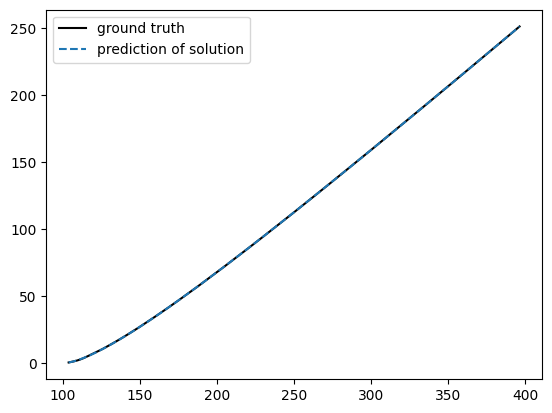

In [129]:
x_data = np.linspace(95, 100, 500)
Candidate_phase.plot_comparison()
Candidate_phase.sympy_expr, Candidate_phase.modified_parameters

In [131]:
import numpy as np
import sympy as sp
from tqdm import tqdm  # For a nice progress bar

def calculate_mse(y_true, y_pred):
    """Calculates the Mean Squared Error between true and predicted values."""
    squared_errors = (np.asarray(y_true) - np.asarray(y_pred))**2
    return np.mean(squared_errors)

def find_best_combination(amplitude_problem, phase_problem, x_data, y_true):
    """
    Iterates over all combinations of amplitude and phase solutions to find the one
    with the lowest Mean Squared Error (MSE).

    Args:
        amplitude_problem: The problem object containing a list of amplitude solutions.
        phase_problem: The problem object containing a list of phase solutions.
        x_data (np.ndarray): The x-values for evaluation.
        y_true (np.ndarray): The true y-values for comparison.

    Returns:
        dict: A dictionary containing the best found combination, including indices,
              MSE, the final symbolic expression, and the solution objects themselves.
    """
    best_mse = float('inf')
    best_amp_index = -1
    best_phase_index = -1
    best_expression = None
    
    X1 = sp.Symbol('X1')
    
    print("Searching for the best combination of Amplitude and Phase solutions...")
    
    # tqdm creates a smart progress bar for the outer loop
    for i, amp_sol in enumerate(tqdm(amplitude_problem.solutions, desc="Amplitude Solutions")):
        for j, phase_sol in enumerate(phase_problem.solutions):
            try:
                # Step 1: Substitute the numerical constants into the symbolic expressions
                A_numeric = amp_sol.sympy_expr.subs(amp_sol.b_vals)
                phi_numeric = phase_sol.sympy_expr.subs(phase_sol.b_vals)
                
                # Step 2: Combine them into the full physics-based expression
                reconstructed_expr = A_numeric * sp.cos(phi_numeric)
                
                # Step 3: Lambdify the expression to create a fast numerical function
                # This handles cases where the expression is just a constant (has no X1)
                if X1 in reconstructed_expr.free_symbols:
                    f_approx = sp.lambdify((X1,), reconstructed_expr, 'numpy')
                else:
                    const_val = float(reconstructed_expr)
                    f_approx = lambda x: np.full_like(x, const_val)

                # Step 4: Predict y-values over the specified interval
                y_pred = f_approx(x_data)
                
                # Skip if the prediction resulted in non-finite numbers (e.g., from 1/0)
                if not np.all(np.isfinite(y_pred)):
                    continue

                # Step 5: Calculate the MSE for this combination
                current_mse = calculate_mse(y_true, y_pred)
                
                # Step 6: If this is the best MSE so far, store the results
                if current_mse < best_mse:
                    best_mse = current_mse
                    best_amp_index = i
                    best_phase_index = j
                    best_expression = reconstructed_expr
                    
            except Exception:
                # If any error occurs during substitution or evaluation,
                # just skip to the next combination.
                continue
    
    if best_amp_index == -1:
        print("\nWarning: No valid combination was found.")
        return None
        
    print("\n--- Search Complete ---")
    print(f"Lowest MSE found: {best_mse:.6e}")
    print(f"Achieved with Amplitude solution index: {best_amp_index}")
    print(f"And Phase solution index: {best_phase_index}")
    
    return {
        'best_mse': best_mse,
        'best_amp_index': best_amp_index,
        'best_phase_index': best_phase_index,
        'best_amp_solution': amplitude_problem.solutions[best_amp_index],
        'best_phase_solution': phase_problem.solutions[best_phase_index],
        'best_expression': best_expression
    }

# Assume the following objects and data are already loaded:
# - amplitude_bessel_0: Your problem object with amplitude solutions
# - phase_bessel_0: Your problem object with phase solutions
# - x_data: The numpy array of x-values for evaluation
# - y_true: The numpy array of the true Bessel function values
x_data = np.linspace(95, 300, 500)
y_true = special.jv(order, x_data)
# Call the function to start the search
best_combination = find_best_combination(
    amplitude_problem=amplitude_bessel_0,
    phase_problem=phase_bessel_0,
    x_data=x_data,
    y_true=y_true
)

# You can now access the results from the returned dictionary
if best_combination:
    print("\n--- Best Found Symbolic Model ---")
    print(best_combination['best_expression'])
    
    # You can now take this best_combination and use it in your plotting script
    # For example:
    # bessel_approx_expr = best_combination['best_expression']
    # ... then lambdify and plot as you did before.

Searching for the best combination of Amplitude and Phase solutions...


Amplitude Solutions:  20%|██        | 6/30 [00:01<00:03,  6.10it/s]<lambdifygenerated-170>:2: RuntimeWarning: invalid value encountered in sqrt
  return (0.0780803039669991*sqrt(0.0337517932057381*X1 - 3.37998986244202)/(0.0337517932057381*X1 - 3.27386164665222) + 0.0177101567387581)*cos(0.888267205978991*X1 - 106.253440856934)
<lambdifygenerated-171>:2: RuntimeWarning: invalid value encountered in sqrt
  return (0.0780803039669991*sqrt(0.0337517932057381*X1 - 3.37998986244202)/(0.0337517932057381*X1 - 3.27386164665222) + 0.0177101567387581)*cos(0.887232646811754*X1 - 106.068824768066)
<lambdifygenerated-172>:2: RuntimeWarning: invalid value encountered in sqrt
  return (0.0780803039669991*sqrt(0.0337517932057381*X1 - 3.37998986244202)/(0.0337517932057381*X1 - 3.27386164665222) + 0.0177101567387581)*cos(1.01305135435041*X1 - 165.490417480469 + 6116.80299911276/X1)
<lambdifygenerated-173>:2: RuntimeWarning: invalid value encountered in sqrt
  return (0.0780803039669991*sqrt(0.0337517932


--- Search Complete ---
Lowest MSE found: 8.890402e-05
Achieved with Amplitude solution index: 2
And Phase solution index: 16

--- Best Found Symbolic Model ---
(0.010974396020174 + 10.491794148722/X1)*cos(0.306979661943274*X1**2/(0.305592656135559*X1 - 1.32657635211945) - 0.515139289990088*X1/(-0.0020605134844538*X1**2 + 1.35179037469652*X1 - 5.82928714946047) + 362.482548474974*X1/(0.305592656135559*X1 - 1.32657635211945) - 1349.71862792969 + 310428.885078132/(0.484203681180873*X1**3 - 43.9978587587902*X1**2 + 181.870056481275*X1))


Overall Mean Squared Error (MSE): 6.991211e-08


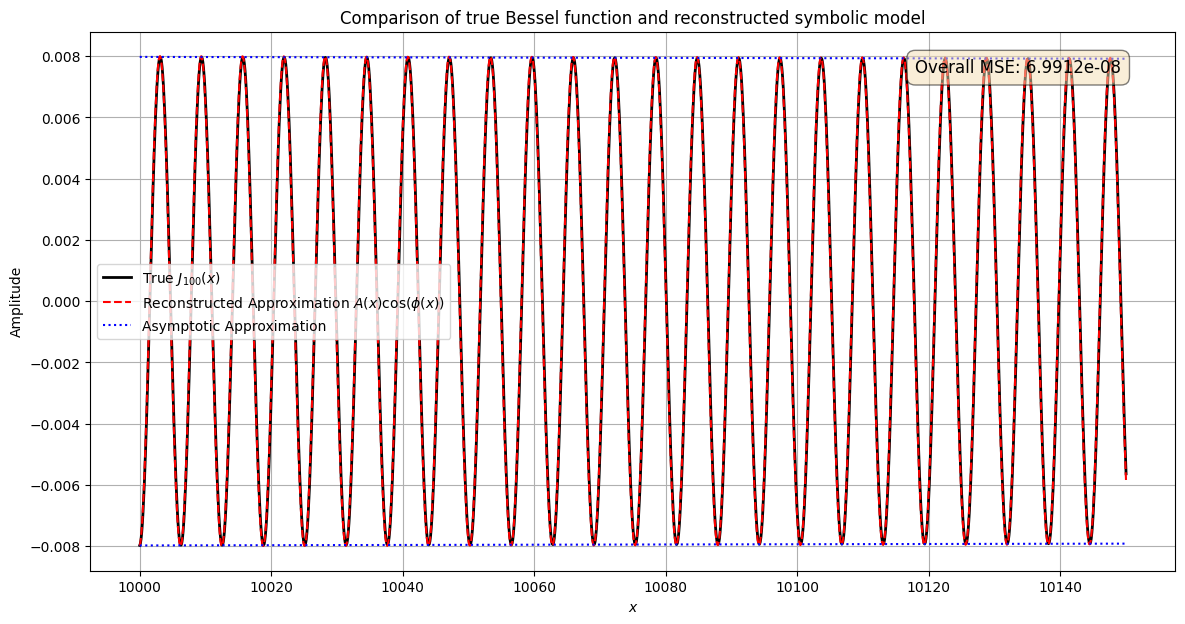

In [344]:

# 1. Define the symbolic variable
X1 = sp.Symbol('X1')

# 2. Extract the solution objects
# amp_solution = amplitude_bessel_0.solutions[4]
# phase_solution = phase_bessel_0.solutions[10]

amp_solution = Candidate_ampl
phase_solution = Candidate_phase


# 3. Get the symbolic expressions
A_expr = amp_solution.sympy_expr
phi_expr = phase_solution.sympy_expr

# --- STEP 1: SUBSTITUTE NUMERICAL CONSTANTS ---
# This is the critical new step.
# NOTE: You might need to change '.params' to the correct attribute name 
# that holds the dictionary of constant values (e.g., .constants_).
# A_numeric_expr = A_expr.subs(amp_solution.b_vals)
# phi_numeric_expr = phi_expr.subs(phase_solution.b_vals)

A_numeric_expr = A_expr.subs(amp_solution.modified_parameters)
phi_numeric_expr = phi_expr.subs(phase_solution.modified_parameters)

# 4. Combine the now-numeric expressions
bessel_approx_expr = A_numeric_expr * sp.cos(phi_numeric_expr)

# print("--- Final Expression with Numerical Constants ---")
# print(bessel_approx_expr)
# print("-" * 50)

# 5. Lambdify the final expression
# This now works because the only symbol left is X1.
# We keep the modules fix to be safe.
f_bessel_approx = sp.lambdify(
    (X1,), 
    bessel_approx_expr, 
    modules=[{'sqrt': np.sqrt, 'sin': np.sin}, 'numpy']
)

# 6. Generate data and plot (same as before)
x_data = np.linspace(10000, 10150, 1500)
y_true = special.jv(order, x_data)

# This call will now succeed.
y_pred = f_bessel_approx(x_data)


# Assuming y_true and y_pred have been calculated
overall_mse = calculate_mse(y_true, y_pred)

print(f"Overall Mean Squared Error (MSE): {overall_mse:.6e}")


# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(14, 7))

# Use the 'ax' object for all plotting commands
ax.plot(x_data, y_true, label=f'True $J_{{{order}}}(x)$', color='black', linewidth=2)
ax.plot(x_data, y_pred, label=r'Reconstructed Approximation $A(x) \cos(\phi(x)) $', color='red', linestyle='--')
ax.plot(x_data, np.sqrt(2/(np.pi*x_data)), label='Asymptotic Approximation', color='blue', linestyle=':')
ax.plot(x_data, -np.sqrt(2/(np.pi*x_data)), color='blue', linestyle=':')


# Set titles and labels on the axes object
ax.set_title('Comparison of true Bessel function and reconstructed symbolic model')
ax.set_xlabel('$x$')
ax.set_ylabel('Amplitude') # Added a Y-axis label for completeness
ax.legend()
ax.grid(True)

# The ax.text call will now work correctly
# (Assuming overall_mse is already calculated)
mse_text = f"Overall MSE: {overall_mse:.4e}"
ax.text(0.95, 0.95, mse_text, 
        transform=ax.transAxes, 
        fontsize=12,
        verticalalignment='top', 
        horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# Use plt.show() to display the figure
#plt.ylim(-0.3, 0.3)
plt.show()


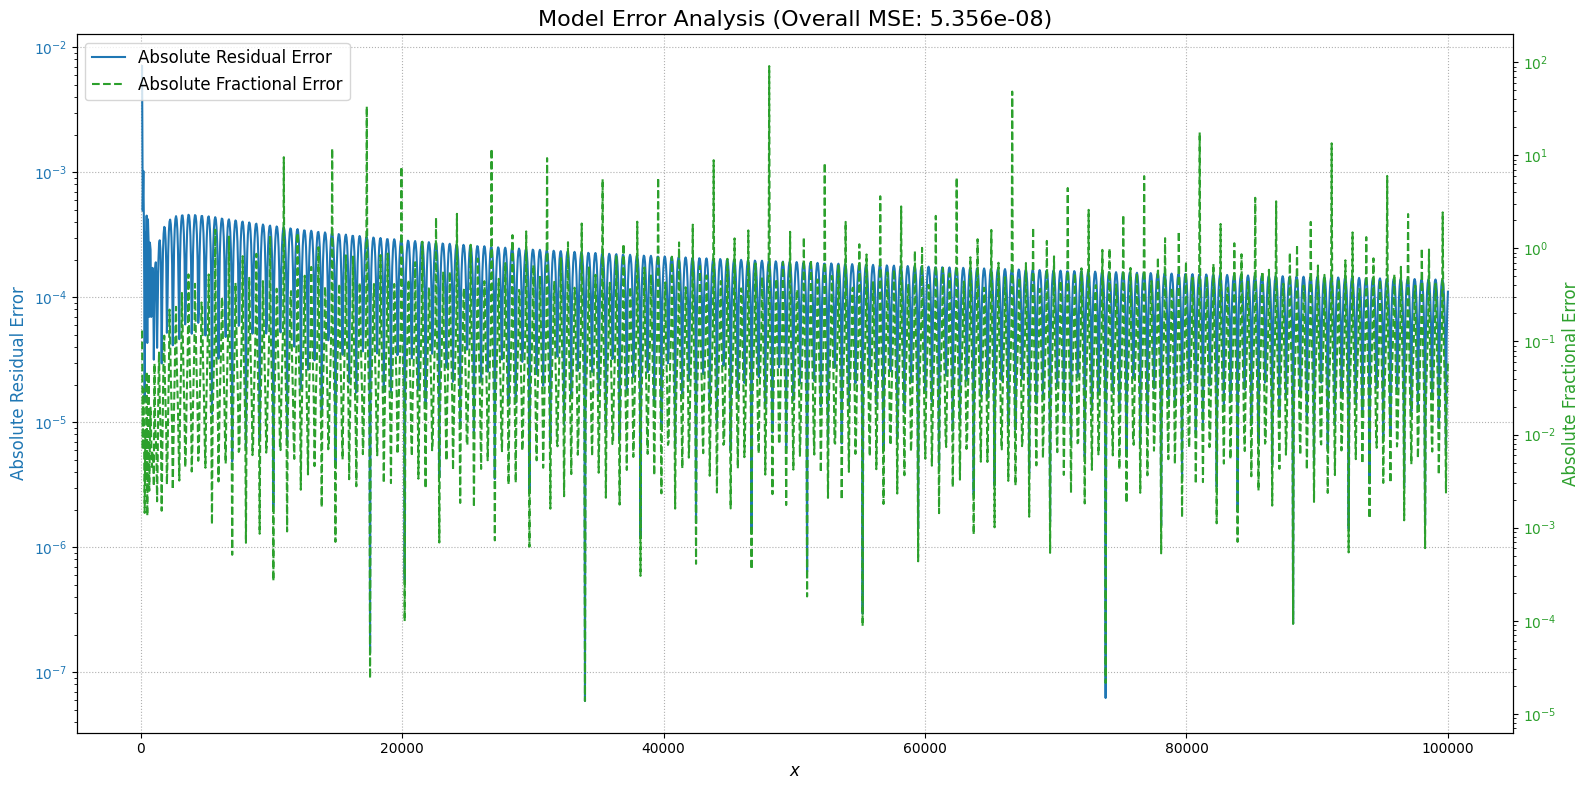

In [133]:
# Assume your calculate_mse function is defined elsewhere in your notebook
def calculate_mse(y_true, y_pred):
    return np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)

def plot_error_analysis(amp_candidate, phase_candidate, order_val, 
                        x_range=(110, 100000), num_points=2000,
                        plot_residual_abs=True, plot_fractional=True):
    """
    Generates a focused plot of the model's error, with options to show
    absolute residual error and/or fractional error.

    Args:
        amp_candidate: Your fitted candidate object for the amplitude.
        phase_candidate: Your fitted candidate object for the phase.
        order_val (int): The order of the Bessel function for the true data.
        x_range (tuple): The (start, end) of the x-axis for plotting.
        num_points (int): The number of points to generate for the plot.
        plot_residual_abs (bool): If True, plots the absolute residual error.
        plot_fractional (bool): If True, plots the absolute fractional error.
    """
    if not plot_residual_abs and not plot_fractional:
        print("No plots requested. Set 'plot_residual_abs' or 'plot_fractional' to True.")
        return

    X1 = sp.Symbol('X1')

    # 1. Prepare and lambdify the symbolic model
    A_expr = amp_candidate.sympy_expr.subs(amp_candidate.modified_parameters)
    phi_expr = phase_candidate.sympy_expr.subs(phase_candidate.modified_parameters)
    bessel_approx_expr = A_expr * sp.cos(phi_expr)
    f_bessel_approx = sp.lambdify((X1,), bessel_approx_expr, modules=['numpy'])

    # 2. Generate data
    x_data = np.linspace(x_range[0], x_range[1], num_points)
    y_true = special.jv(order_val, x_data)
    y_pred = f_bessel_approx(x_data)

    # 3. Calculate error metrics
    mse = calculate_mse(y_true, y_pred)
    residuals = y_true - y_pred
    absolute_residual_error = np.abs(residuals)
    
    epsilon = 1e-12 
    fractional_error = residuals / (np.abs(y_true) + epsilon)
    absolute_fractional_error = np.abs(fractional_error)

    # 4. Create the visualization based on flags
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax1.set_title(f"Model Error Analysis (Overall MSE: {mse:.3e})", fontsize=16)
    ax1.set_xlabel('$x$', fontsize=12)
    ax1.grid(True, linestyle=':')

    # Case 1: Plot both using a twin axis
    if plot_residual_abs and plot_fractional:
        ax2 = ax1.twinx()
        line1 = ax1.plot(x_data, absolute_residual_error, color='#1f77b4', label='Absolute Residual Error')
        ax1.set_ylabel('Absolute Residual Error', color='#1f77b4', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='#1f77b4')
        ax1.set_yscale("log")

        line2 = ax2.plot(x_data, absolute_fractional_error, color='#2ca02c', linestyle='--', label='Absolute Fractional Error')
        ax2.set_ylabel('Absolute Fractional Error', color='#2ca02c', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='#2ca02c')
        ax2.set_yscale("log")
        
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=12)

    # Case 2: Plot only the absolute residual error
    elif plot_residual_abs:
        ax1.plot(x_data, absolute_residual_error, color='#1f77b4', label='Absolute Residual Error')
        ax1.set_ylabel('Absolute Residual Error', fontsize=12)
        ax1.set_yscale("log")
        ax1.legend(loc='upper left', fontsize=12)

    # Case 3: Plot only the fractional error
    elif plot_fractional:
        ax1.plot(x_data, absolute_fractional_error, color='#2ca02c', linestyle='--', label='Absolute Fractional Error')
        ax1.set_ylabel('Absolute Fractional Error', fontsize=12)
        ax1.set_yscale("log")
        ax1.legend(loc='upper left', fontsize=12)

    plt.tight_layout()
    plt.show()

# --- HOW TO USE THE FUNCTION ---
# This cell should be run AFTER your cell where 'Candidate_ampl', 
# 'Candidate_phase', and 'order' are defined.

# Example 1: Plot both (default behavior)
# plot_error_analysis(Candidate_ampl, Candidate_phase, order)

# Example 2: Plot only the absolute residual error
# plot_error_analysis(Candidate_ampl, Candidate_phase, order, plot_fractional=False)

# Example 3: Plot only the absolute fractional error
plot_error_analysis(Candidate_ampl, Candidate_phase, order, plot_residual_abs=True)

Bessel function J_100(x) first peak found at x ≈ 103.76
--- Running Sampler with Spline Envelope Tail ---
Peak found at x ≈ 103.76
Pre-peak sampling zones within [0.10, 103.76]:
  - Initial zone:  [0.10, 87.76] with 40 points.
  - Rise-to-Peak:  [87.76, 103.76] with 200 points.
Synthetic tail generation:
  - Spline Tail: [113.76, 233.76] with 20 points.
Generated 259 unique sample points in total.
------------------------------------------


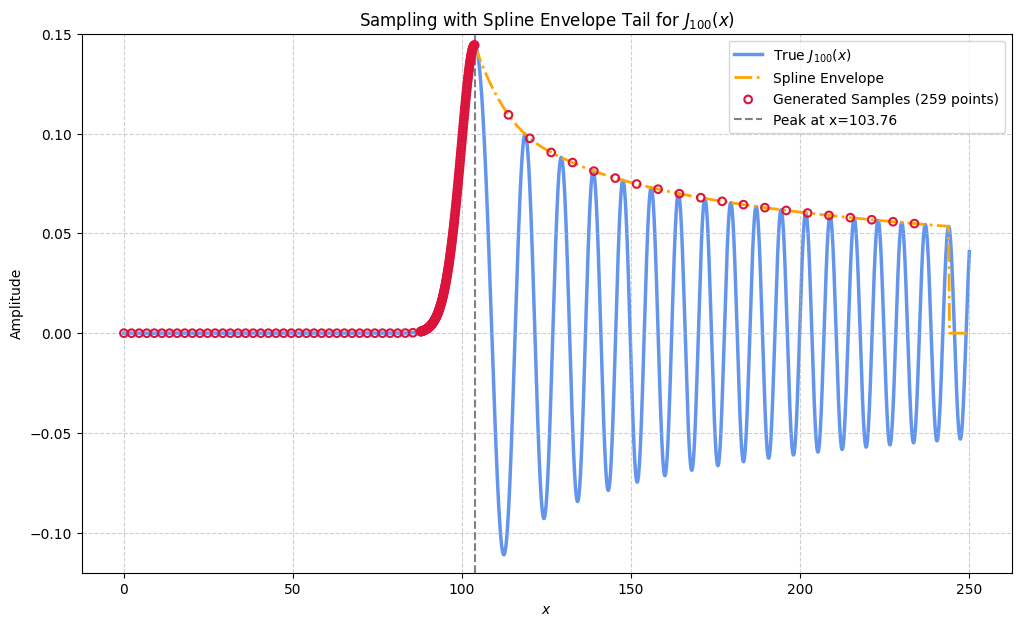

In [772]:
def sampler_with_spline_tail(
    x_original: np.ndarray, y_original: np.ndarray,
    envelope_function,
    n_initial_zone: int, n_rise_zone: int,
    n_dummies: int, x_offset_from_peak: float, dummy_range_width: float,
    rise_window_width: float = 25.0,
    sampling_modes: List[str] = ['linear', 'linear']
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Resamples a curve by sampling up to its peak and then appending a
    synthetically generated tail based on a provided spline envelope function.

    - Zone 1 (Initial): Samples from the start up to the beginning of the main rise.
    - Zone 2 (Rise-to-Peak): Samples the region of steep ascent to the peak.
    - Zone 3 (Spline Tail): Generates points starting at an offset from the
      peak, with y-values calculated from the provided envelope_function.
    """
    print("--- Running Sampler with Spline Envelope Tail ---")

    # Find the peak in the provided data segment
    if len(y_original) == 0:
        print("Warning: Input data is empty. Returning empty arrays.")
        return np.array([]), np.array([])
    peak_index = np.argmax(y_original)
    x_peak = x_original[peak_index]
    print(f"Peak found at x ≈ {x_peak:.2f}")

    start_x = x_original[0]

    # --- Step 1: Sample the region up to the peak ---
    rise_start = max(start_x, x_peak - rise_window_width)

    print(f"Pre-peak sampling zones within [{start_x:.2f}, {x_peak:.2f}]:")
    print(f"  - Initial zone:  [{start_x:.2f}, {rise_start:.2f}] with {n_initial_zone} points.")
    print(f"  - Rise-to-Peak:  [{rise_start:.2f}, {x_peak:.2f}] with {n_rise_zone} points.")

    def generate_samples(start, end, num, mode):
        if start >= end or num <= 0: return np.array([])
        if num == 1: return np.array([start])
        if mode == 'log': return np.geomspace(max(start, 1e-9), end, num)
        return np.linspace(start, end, num)

    x_samples_initial = generate_samples(start_x, rise_start, n_initial_zone, sampling_modes[0])
    x_samples_rise = generate_samples(rise_start, x_peak, n_rise_zone, sampling_modes[1])

    x_pre_peak = np.unique(np.concatenate([x_samples_initial, x_samples_rise]))
    
    # Interpolate y-values for the pre-peak part from the original signal
    interp_func = interp1d(x_original, y_original, kind='cubic', bounds_error=False, fill_value="extrapolate")
    y_pre_peak = interp_func(x_pre_peak)

    # --- Step 2: Generate the synthetic spline tail ---
    dummy_start_x = x_peak + x_offset_from_peak
    dummy_end_x = dummy_start_x + dummy_range_width
    
    print(f"Synthetic tail generation:")
    print(f"  - Spline Tail: [{dummy_start_x:.2f}, {dummy_end_x:.2f}] with {n_dummies} points.")
    
    x_dummies = np.linspace(dummy_start_x, dummy_end_x, n_dummies)
    # Calculate y-values directly from the provided spline envelope function
    y_dummies = envelope_function(x_dummies)

    # --- Step 3: Combine pre-peak and tail data ---
    x_sampled = np.concatenate([x_pre_peak, x_dummies])
    y_sampled = np.concatenate([y_pre_peak, y_dummies])
    
    # Sort by x-value for clean processing and plotting
    sort_indices = np.argsort(x_sampled)
    x_sampled = x_sampled[sort_indices]
    y_sampled = y_sampled[sort_indices]

    print(f"Generated {len(x_sampled)} unique sample points in total.")
    print("------------------------------------------")

    return x_sampled, y_sampled

# --- Main Script ---

# 1. Define parameters and generate the "true" function data
order = 100
x_full = np.linspace(0.1, 250, 8000)
y_full = special.jv(order, x_full)

# 2. Find the first peak of the Bessel function
first_peak_index = np.argmax(y_full)
x_first_peak = x_full[first_peak_index]
print(f"Bessel function J_{order}(x) first peak found at x ≈ {x_first_peak:.2f}")

# 3. Create the spline envelope function from the signal's peaks
# Find all positive peaks in the signal
peaks_indices, _ = find_peaks(y_full, distance=10)
x_peaks = x_full[peaks_indices]
y_peaks = y_full[peaks_indices]
# Create an interpolating function from these peaks
envelope_function = interp1d(x_peaks, y_peaks, kind='cubic', bounds_error=False, fill_value=0)

# 4. Apply the new sampler, passing the envelope function
x_sampled, y_sampled = sampler_with_spline_tail(
    x_original=x_full,
    y_original=y_full,
    envelope_function=envelope_function,
    n_initial_zone=40,
    n_rise_zone=200,
    n_dummies=20,
    x_offset_from_peak=10.0,
    dummy_range_width=120.0,
    rise_window_width=16.0
)

# 5. Plot the results
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the true Bessel function curve
ax.plot(x_full, y_full,
        label=f'True $J_{{{order}}}(x)$',
        color='cornflowerblue',
        linewidth=2.5,
        zorder=1)

# Plot the spline envelope for comparison
x_envelope = np.linspace(x_first_peak, x_full[-1], 500)
y_envelope = envelope_function(x_envelope)
ax.plot(x_envelope, y_envelope,
        label='Spline Envelope',
        color='orange',
        linestyle='-.',
        linewidth=2,
        zorder=3)

# Plot the non-uniformly sampled points
ax.scatter(x_sampled, y_sampled,
           s=30,
           facecolors='none',
           edgecolors='crimson',
           linewidth=1.5,
           zorder=5,
           label=f'Generated Samples ({len(x_sampled)} points)')

# Add a vertical line to mark the peak
ax.axvline(x_first_peak, color='gray', linestyle='--', label=f'Peak at x={x_first_peak:.2f}')

ax.set_title(f'Sampling with Spline Envelope Tail for $J_{{{order}}}(x)$')
ax.set_xlabel('$x$')
ax.set_ylabel('Amplitude')
ax.set_ylim(-0.12, 0.15)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [773]:
prepeak_amplitude_bessel_0_args = {
    'allowed_symbols': "add,sub,mul,div,constant,variable,log",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'], 
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 60,
    'max_time': 60*3,
    'n_threads': 12,
#    'tournament_size': 3
}

prepeak_amplitude_bessel_0 = Problem(f"Prepeak amplitude of Bessel (Hilbert decomp) of {order}", (x_sampled,  np.log(y_sampled)), (x_sampled, np.log(y_sampled)), prepeak_amplitude_bessel_0_args)

<Axes: title={'center': 'Prepeak amplitude of Bessel (Hilbert decomp) of 100 train'}, xlabel='X-axis', ylabel='Y-axis'>

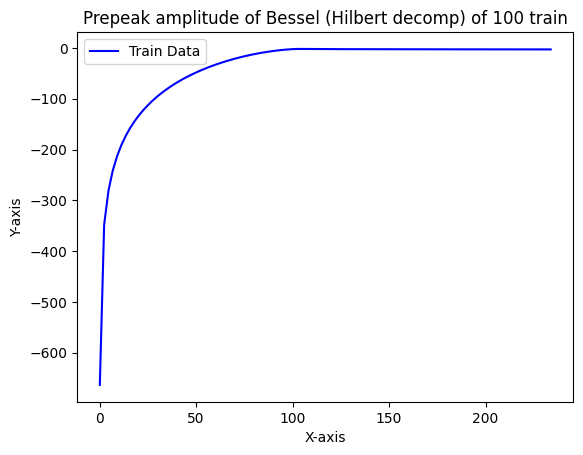

In [774]:
prepeak_amplitude_bessel_0.plot_data()

In [775]:
prepeak_amplitude_bessel_0.solve()

[47.89206314086914, 5.0], 297295.94, ((-113.974136352539062500) + (0.762320995330810547 * (1.334493279457092285 * X1))), 2293.65
[15.229113578796387, 6.0], 30309.27, ((-632.635192871093750000) + (83.579627990722656250 * log((18.558717727661132812 * X1)))), 231.93
[12.165767669677734, 7.0], 19445.13, ((-1802.543701171875000000) + (740.060424804687500000 * log(log((847.612670898437500000 * X1))))), 148.01
[3.7398271560668945, 8.0], 2102.40, ((-1014.910217285156250000) + (109.360885620117187500 * (log((194.983367919921875000 * X1)) - (0.006273963954299688 * X1)))), 13.99
[2.546111583709717, 10.0], 1137.15, ((-701.590270996093750000) + ((-117.179656982421875000) * ((0.006617880426347256 * X1) - log(((7.535956382751464844 * X1) - (-0.646120905876159668)))))), 6.48
[1.970275640487671, 11.0], 806.96, ((-622.073791503906250000) + ((-135.540359497070312500) * ((0.006617880426347256 * X1) - log(((1.801623463630676270 * X1) + log((17.458755493164062500 * X1))))))), 3.88
[1.9115828275680542, 13.0]

<Axes: title={'center': 'Prepeak amplitude of Bessel (Hilbert decomp) of 100 - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

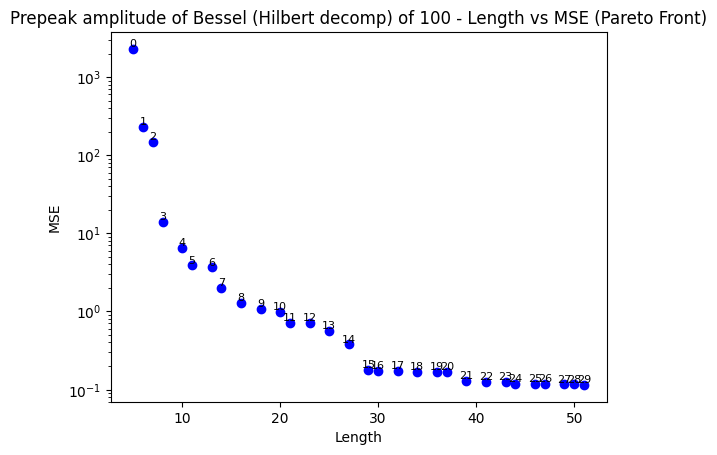

In [776]:
prepeak_amplitude_bessel_0.plot_l_vs_mse()

-X1**4*b0/(X1**4*b1 - X1**3*b2 - X1**2*b3*log(X1) + X1**2*b4 + X1*b5*log(X1) - X1*b6) - X1**3*b7/(X1**4*b1 - X1**3*b2 - X1**2*b3*log(X1) + X1**2*b4 + X1*b5*log(X1) - X1*b6) - X1**2*b8 + X1**2*b9/(X1**4*b1 - X1**3*b2 - X1**2*b3*log(X1) + X1**2*b4 + X1*b5*log(X1) - X1*b6) + X1*b10/(X1**4*b1 - X1**3*b2 - X1**2*b3*log(X1) + X1**2*b4 + X1*b5*log(X1) - X1*b6) + b11*log(X1**2*b12 + X1*b13) - b14


<IPython.core.display.Math object>

{'b0': 1.988192913496018e-06,
 'b1': 3.416982843287993e-07,
 'b2': 6.895594139898209e-05,
 'b3': 0.02435064772135931,
 'b4': 0.11513465486596886,
 'b5': 4.914048194885254,
 'b6': 23.864827079640236,
 'b7': 6.302062730680069e-05,
 'b8': 0.001546075304996064,
 'b9': 0.2053296535305833,
 'b10': 6.508424550932432,
 'b11': 99.93551635742188,
 'b12': 0.00013574771611948866,
 'b13': 0.26821595430374146,
 'b14': 301.48040771484375}

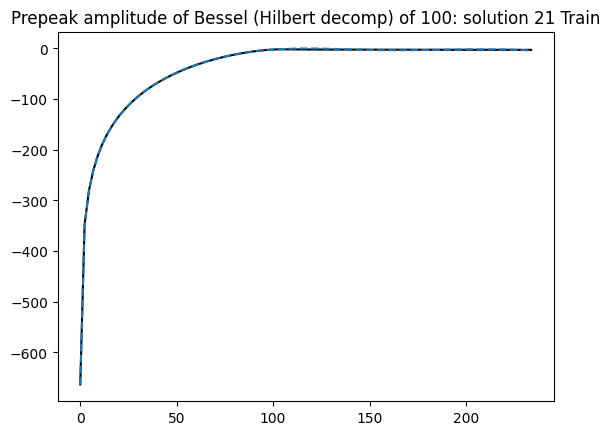

In [779]:
c_prepeak_amp = 21
print(str(prepeak_amplitude_bessel_0.solutions[c_prepeak_amp].sympy_expr))
prepeak_amplitude_bessel_0.solutions[c_prepeak_amp].plot_results()

prepeak_amplitude_bessel_0.solutions[c_prepeak_amp].display_expression()
prepeak_amplitude_bessel_0.solutions[c_prepeak_amp].b_vals

/tmp/ipykernel_224719/2611975551.py:4: RuntimeWarning: overflow encountered in exp
  plt.plot(x_alter, np.exp(prepeak_amplitude_bessel_0.solutions[c_prepeak_amp].regressor.evaluate_model(prepeak_amplitude_bessel_0.solutions[c_prepeak_amp].tree,x_alter.reshape(-1,1))), label='Fitted', color='red')


(-0.12, 0.15)

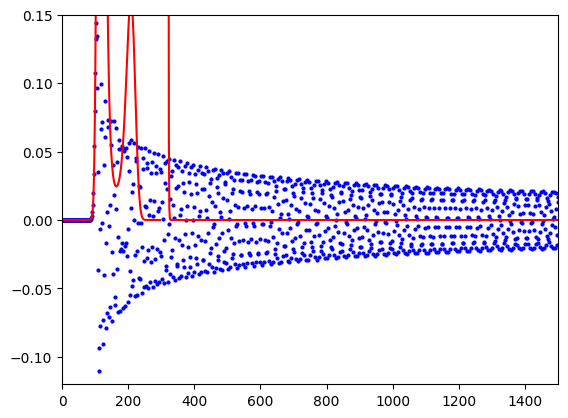

In [782]:
limit_x = 1500
x_alter = np.linspace(0, limit_x, 1000)

plt.plot(x_alter, np.exp(prepeak_amplitude_bessel_0.solutions[c_prepeak_amp].regressor.evaluate_model(prepeak_amplitude_bessel_0.solutions[c_prepeak_amp].tree,x_alter.reshape(-1,1))), label='Fitted', color='red')
plt.scatter(x_alter, special.jv(order, x_alter), label='Data', color='blue', s=4)
plt.xlim(0, limit_x)
plt.ylim(-0.12, 0.15)

In [600]:
str_prepeak_sol = 'X1*b0/(X1*b1 - b2 + b3/(-X1**3*b4 + X1**2*b5) + log(X1) + b6/X1) - b10 + b7*log(X1*b8 + b9)'
Candidate_prepeak_ampl = Promising_solution(sp.parsing.sympy_parser.parse_expr(str_prepeak_sol), (x_sampled, np.log(y_sampled)), prepeak_amplitude_bessel_0.solutions[c_prepeak_amp], prepeak_amplitude_bessel_0.solutions[c_prepeak_amp].b_vals)

In [601]:
Candidate_prepeak_ampl.optimisation()

`xtol` termination condition is satisfied.
Number of iterations: 276, function evaluations: 3312, CG iterations: 2672, optimality: 1.49e+04, constraint violation: 0.00e+00, execution time: 0.53 s.

Optimization summary:
Parameter | Old Value  | New Value  | Abs Difference
--------- | ---------  | ---------  | --------------
b0        | 0.325179   | 0.417514   | 0.0923351     
b1        | 0.00352119 | 0.0061155  | 0.00259431    
b10       | 522.653    | 522.652    | 0.00110179    
b2        | 5.98161    | 6.48971    | 0.508109      
b3        | 11.2916    | 11.1367    | 0.154885      
b4        | 0.00638933 | 0.00639313 | 3.8014e-06    
b5        | 0.705428   | 0.70355    | 0.00187727    
b6        | 1.18413    | 1.16937    | 0.0147601     
b7        | 100.923    | 101.04     | 0.116913      
b8        | 2.39693    | 2.40432    | 0.00738696    
b9        | 0.00845088 | -0.178732  | 0.187183      



(0.417514028952965*X1/(0.00611549979736374*X1 + log(X1) - 6.48971446003163 + 11.1366869291361/(-0.00639313155304929*X1**3 + 0.703550376006201*X1**2) + 1.16936707509962/X1) + 101.040375289955*log(2.4043202753588*X1 - 0.178732420939869) - 522.651669203047,
 {'b0': np.float64(0.41751402895296474),
  'b1': np.float64(0.006115499797363743),
  'b10': np.float64(522.6516692030468),
  'b2': np.float64(6.48971446003163),
  'b3': np.float64(11.13668692913612),
  'b4': np.float64(0.006393131553049292),
  'b5': np.float64(0.7035503760062012),
  'b6': np.float64(1.1693670750996183),
  'b7': np.float64(101.0403752899554),
  'b8': np.float64(2.4043202753587964),
  'b9': np.float64(-0.17873242093986888)},
 {'b0': np.float64(0.09233509028099685),
  'b1': np.float64(0.0025943069784836615),
  'b10': np.float64(0.0011017930469279236),
  'b2': np.float64(0.50810870857533),
  'b3': np.float64(0.15488520107996173),
  'b4': np.float64(3.8014006092604996e-06),
  'b5': np.float64(0.001877270630761707),
  'b6': 

<lambdifygenerated-824>:2: RuntimeWarning: invalid value encountered in log
  return 0.417514028952965*X1/(0.00611549979736374*X1 + log(X1) - 6.48971446003163 + 11.1366869291361/(-0.00639313155304929*X1**3 + 0.703550376006201*X1**2) + 1.16936707509962/X1) + 101.040375289955*log(2.4043202753588*X1 - 0.178732420939869) - 522.651669203047


(-0.13, 0.18)

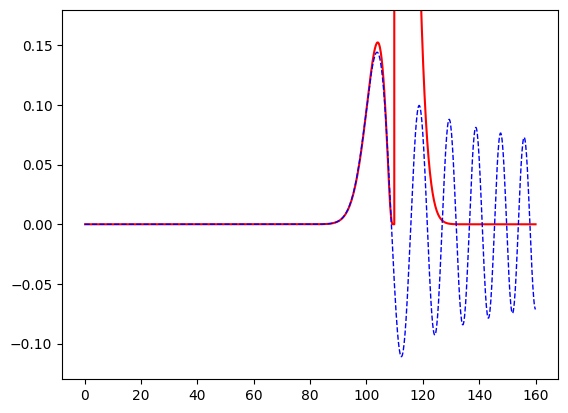

In [786]:
X1 = sp.Symbol('X1')


x = np.linspace(1e-20, 160, 1000)

# Lambdify symbolic expression for fast evaluation
f_lambdified = sp.lambdify(X1, Candidate_prepeak_ampl.numerical_expr, modules='numpy')

# Evaluate predicted values from symbolic expression at x_val
y_pred = np.exp(f_lambdified(x))

plt.plot(x, y_pred, label='Fitted after optimisation', color='red')
plt.plot(x, (special.jv(order, x)), label='Data', color='blue', linestyle='--', linewidth=1)

plt.ylim(-0.13, 0.18)

In [787]:
print('Candidate for oscillatory AMPLITUDE:', str(Candidate_ampl.sympy_expr))
print('Candidate for oscillatory PHASE:', str(Candidate_phase.sympy_expr))
print('Candidate for PREPEAK AMPLITUDE:', str(Candidate_prepeak_ampl.sympy_expr))
print('Candidate for PREPEAK PHASE: ', str('X1*0'))

Candidate for oscillatory AMPLITUDE: b1/(sqrt(X1)*b2 + b6 - sqrt(X1*b3 - b4)/(X1*b3 - b5))
Candidate for oscillatory PHASE: X1**2*b0/(X1*b0 - b2) + X1*b3/(X1*b1 - b2) - b4 + b5/(X1*b6 - b7 + b8/X1)
Candidate for PREPEAK AMPLITUDE: X1*b0/(X1*b1 - b2 + b3/(-X1**3*b4 + X1**2*b5) + log(X1) + b6/X1) - b10 + b7*log(X1*b8 + b9)
Candidate for PREPEAK PHASE:  X1*0


In [788]:
# Assuming Promising_solution class is defined elsewhere
# from your_module import Promising_solution

def create_unified_model(cand_pre_amp: 'Promising_solution',
                         cand_pre_phase_str: str,
                         cand_osc_amp: 'Promising_solution',
                         cand_osc_phase: 'Promising_solution',
                         x_data: np.ndarray,
                         y_data: np.ndarray) -> 'Promising_solution':
    """
    Constructs a single, unified model from pre-peak and oscillatory components
    using a Piecewise hard switch to avoid evaluating component models outside
    of their valid domains.
    The pre-peak amplitude model is assumed to be for log(A(X1)).

    Args:
        cand_pre_amp: Solution for pre-peak log-amplitude, log(A(X1)).
        cand_pre_phase_str: String expression for the pre-peak phase, e.g., "0*X1".
        cand_osc_amp: Solution for oscillatory amplitude.
        cand_osc_phase: Solution for oscillatory phase.
        x_data: The x-values of the dataset.
        y_data: The y-values of the dataset.

    Returns:
        A new Promising_solution instance representing the unified model.
    """
    print("\n--- Creating Unified Model with Piecewise Hard Switch ---")
    X1 = sp.Symbol('X1')
    all_params_symbols = []
    all_param_vals = []
    
    # Define a new parameter for the switch position
    switch_pos = sp.Symbol('switch_pos')
    
    # Find the peak x-value to initialize the switch position
    x_peak_val = x_data[np.argmax(y_data)]
    print(f"Initializing hard switch position at peak location: {x_peak_val:.2f}")
    
    # --- Parameter Re-indexing and Expression Substitution ---
    # This process ensures that parameters from different models don't conflict.
    
    def reindex_and_substitute(candidate: 'Promising_solution', prefix: str):
        """
        Helper to rename parameters and substitute them into the expression,
        only processing parameters that are present in the expression.
        """
        expr = candidate.sympy_expr
        subs_dict = {}
        
        # Get the names of the free symbols present in the expression
        symbols_in_expr = {s.name for s in expr.free_symbols}
        
        param_idx = 0 # Use a separate counter for the new parameter index
        
        # Use .modified_parameters which is a dict {name: value}
        for param_name, val in candidate.modified_parameters.items():
            # Check if the parameter from the dictionary is actually in the expression
            if param_name in symbols_in_expr:
                # Create the symbol to be replaced directly from its name string
                original_param_symbol = sp.Symbol(param_name)
                
                # Create the new, re-indexed symbol using the clean counter
                new_param_symbol = sp.Symbol(f'{prefix}_{param_idx}')
                
                # Add the new symbol and its value to the main lists
                all_params_symbols.append(new_param_symbol)
                all_param_vals.append(val)
                
                # Prepare the substitution dictionary
                subs_dict[original_param_symbol] = new_param_symbol
                
                # Increment the counter for the next valid parameter
                param_idx += 1
            
        return expr.subs(subs_dict)

    # Re-index parameters for each component model
    log_pre_amp_expr_new = reindex_and_substitute(cand_pre_amp, 'pa') # Model for log(Pre-peak Amplitude)
    pre_amp_expr_new = sp.exp(log_pre_amp_expr_new)                   # Calculate actual amplitude A(X1)

    # Parse the pre-peak phase string directly, no re-indexing needed as it has no parameters
    print(f"Parsing pre-peak phase string: '{cand_pre_phase_str}'")
    pre_phase_expr_new = sp.parsing.sympy_parser.parse_expr(cand_pre_phase_str)

    osc_amp_expr_new = reindex_and_substitute(cand_osc_amp, 'oa')     # Oscillatory Amplitude
    osc_phase_expr_new = reindex_and_substitute(cand_osc_phase, 'op') # Oscillatory Phase
    
    # Add the switch position parameter to the list for optimization
    all_params_symbols.append(switch_pos)
    all_param_vals.append(x_peak_val+5.0)

    # --- Construct the Combined Expressions using sp.Piecewise ---
    # This creates a hard switch. The function will ONLY evaluate the relevant
    # expression within the specified domain, preventing NaN/overflow errors.
    combined_amplitude = sp.Piecewise(
        (pre_amp_expr_new, X1 < switch_pos),
        (osc_amp_expr_new, True)  # 'True' acts as the otherwise/else condition
    )
    
    combined_phase = sp.Piecewise(
        (pre_phase_expr_new, X1 < switch_pos),
        (osc_phase_expr_new, True)
    )

    # Final model expression: A(X1) * cos(phi(X1))
    final_expr = combined_amplitude * sp.cos(combined_phase)
    
    print("Successfully created unified model using Piecewise.")
    print("NOTE: The model may not be continuously differentiable at the switch point.")
    print("--------------------------------")
    
    # Create the dictionary of initial parameters for the new unified model
    initial_params_dict = {str(p): v for p, v in zip(all_params_symbols, all_param_vals)}

    # This part requires the definition of Promising_solution to work.
    # It is assumed to be available in the execution context.
    # from your_module import Promising_solution

    # Create and return the new, unified solution object using the correct __init__
    unified_solution = Promising_solution(
        sympy_expr=final_expr,
        test_data=(x_data, y_data),
        solution=all_params_symbols, # The list of new sympy symbols
        initial_parameters=initial_params_dict # The dict of {name: value}
    )
    subs_dict_for_numerical = dict(zip(all_params_symbols, all_param_vals))
    unified_solution.numerical_expr = final_expr.subs(subs_dict_for_numerical)
    
    return unified_solution



In [789]:
unified_model = create_unified_model(Candidate_prepeak_ampl, '0*X1', Candidate_ampl, Candidate_phase, x_data_trimmed, y_true_bessel_trimmed)


--- Creating Unified Model with Piecewise Hard Switch ---
Initializing hard switch position at peak location: 103.70
Parsing pre-peak phase string: '0*X1'
Successfully created unified model using Piecewise.
NOTE: The model may not be continuously differentiable at the switch point.
--------------------------------


In [790]:
unified_model.initial_params

{'pa_0': np.float64(0.41751402895296474),
 'pa_1': np.float64(0.006115499797363743),
 'pa_2': np.float64(522.6516692030468),
 'pa_3': np.float64(6.48971446003163),
 'pa_4': np.float64(11.13668692913612),
 'pa_5': np.float64(0.006393131553049292),
 'pa_6': np.float64(0.7035503760062012),
 'pa_7': np.float64(1.1693670750996183),
 'pa_8': np.float64(101.0403752899554),
 'pa_9': np.float64(2.4043202753587964),
 'pa_10': np.float64(-0.17873242093986888),
 'oa_0': np.float64(0.21801642083702774),
 'oa_1': np.float64(0.26951670820599183),
 'oa_2': np.float64(0.03390378982759867),
 'oa_3': np.float64(3.380473739000799),
 'oa_4': np.float64(3.280598506780052),
 'oa_5': np.float64(0.3314396476013858),
 'op_0': np.float64(0.3059523488315124),
 'op_1': np.float64(0.30546195228130724),
 'op_2': np.float64(1.2788004867503875),
 'op_3': np.float64(350.18028672508893),
 'op_4': np.float64(1308.3862019698174),
 'op_5': np.float64(50.872348912308546),
 'op_6': np.float64(0.48919804965287406),
 'op_7': n

<lambdifygenerated-826>:2: RuntimeWarning: invalid value encountered in power
  return select([less(X1, 108.703703703704),True], [1.03577185934723e-227*(2.4043202753588*X1 - 0.178732420939869)**101.040375289955*exp(0.417514028952965*X1/(0.00611549979736374*X1 + log(X1) - 6.48971446003163 + 11.1366869291361/(-0.00639313155304929*X1**3 + 0.703550376006201*X1**2) + 1.16936707509962/X1)),0.218016420837028/(0.269516708205992*sqrt(X1) - sqrt(0.0339037898275987*X1 - 3.3804737390008)/(0.0339037898275987*X1 - 3.28059850678005) + 0.331439647601386)], default=nan)*cos(select([less(X1, 108.703703703704),True], [0,0.305952348831512*X1**2/(0.305952348831512*X1 - 1.27880048675039) + 350.180286725089*X1/(0.305461952281307*X1 - 1.27880048675039) - 1308.38620196982 + 50.8723489123085/(0.489198049652874*X1 - 43.859246722962 + 176.868325533987/X1)], default=nan))
<lambdifygenerated-826>:2: RuntimeWarning: divide by zero encountered in log
  return select([less(X1, 108.703703703704),True], [1.0357718593472

<Axes: >

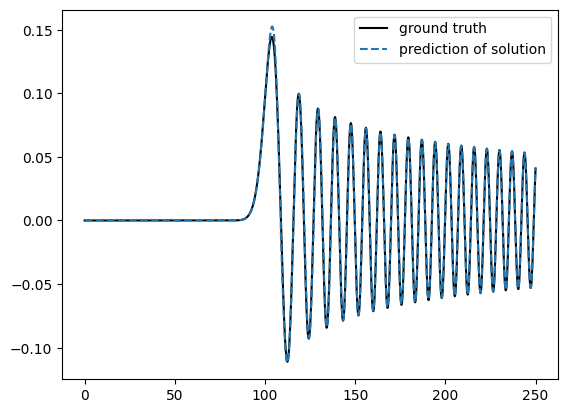

In [792]:

x_prime = np.linspace(0, 250, 2000)
y_prime = special.jv(order, x_prime)

unified_model.plot_comparison(x_prime, y_prime)
